In [28]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob
import json
plt.ion()

Load in all the data - the file names are included in the json file organized by event (there are 4 of them).

In [50]:
# Read in data, from both Livingston and Haverford, need to specify which event (4 of them)

data_directory = 'LOSC_Event_tutorial/'

with open(data_directory+'BBH_events_v3.json') as file:
    json_dat = json.load(file)

list_events = list(json_dat.keys())
print('Different event names: ', list_events)

Different event names:  ['GW150914', 'LVT151012', 'GW151226', 'GW170104']


In [51]:
# functions from simple_read_ligo.py

def read_template(filename,):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [67]:
# Read in all data, make separate lists for H1,L1 data and templates
N_events = len(list_events)
H1_data = [] # data for Hanford events (strain,dt,utc)
L1_data = [] # data for Livingston events
H_templates = [] # templates for Hanford for each event
L_templates = [] # templates for Livingston for each event

for i in range(N_events):
    event_name = str(list_events[i])
    H1_fname = json_dat[event_name]['fn_H1']
    L1_fname = json_dat[event_name]['fn_L1']
    fn_temp = json_dat[event_name]['fn_template']
    H1_data.append(read_file(data_directory+H1_fname))
    L1_data.append(read_file(data_directory+L1_fname))
    H_temp, L_temp = read_template(data_directory+fn_temp)
    H_templates.append(H_temp), L_templates.append(L_temp);
    
file.close() # close json object

We can plot the data for each event along with the corresponding template.

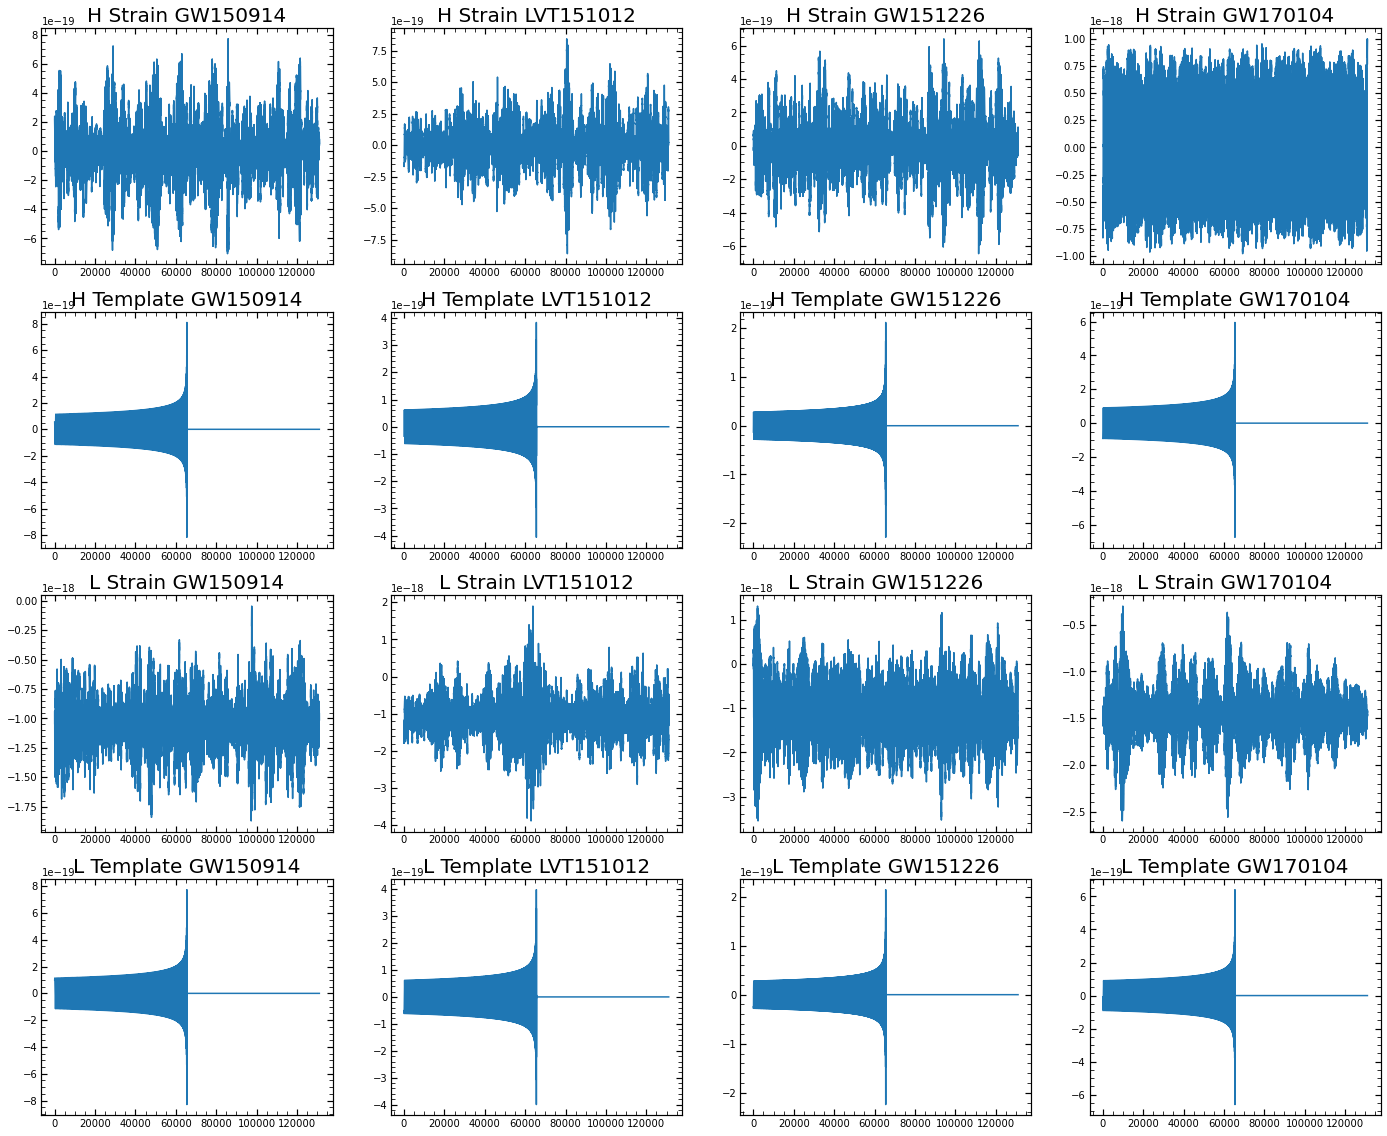

In [76]:
nrows, ncols = 4,4
fig,ax = plt.subplots(nrows,ncols, figsize=[24,20])

for j in range(ncols):
    ax[0,j].plot(H1_data[j][0])
    ax[0,j].set_title('H Strain '+str(list_events[j]), fontsize=20)
    ax[1,j].plot(H_templates[j])
    ax[1,j].set_title('H Template '+str(list_events[j]), fontsize=20)
    ax[2,j].plot(L1_data[j][0])
    ax[2,j].set_title('L Strain '+str(list_events[j]), fontsize=20)
    ax[3,j].plot(L_templates[j])
    ax[3,j].set_title('L Template '+str(list_events[j]), fontsize=20)

# Q1a) Come up with a noise model for the Livingston and Hanford detectors separately. Describe how you do this in comments. Please mention something about how you smooth the power spectrum and how you deal with lines. Please also explain how you window your data (you may want to use a window that has an extedned flat period near the centre to avoud tapering the data/template where the signal is not small).

First we can plot the power spectra of each event to get an idea of the the lines that we would like to smooth.

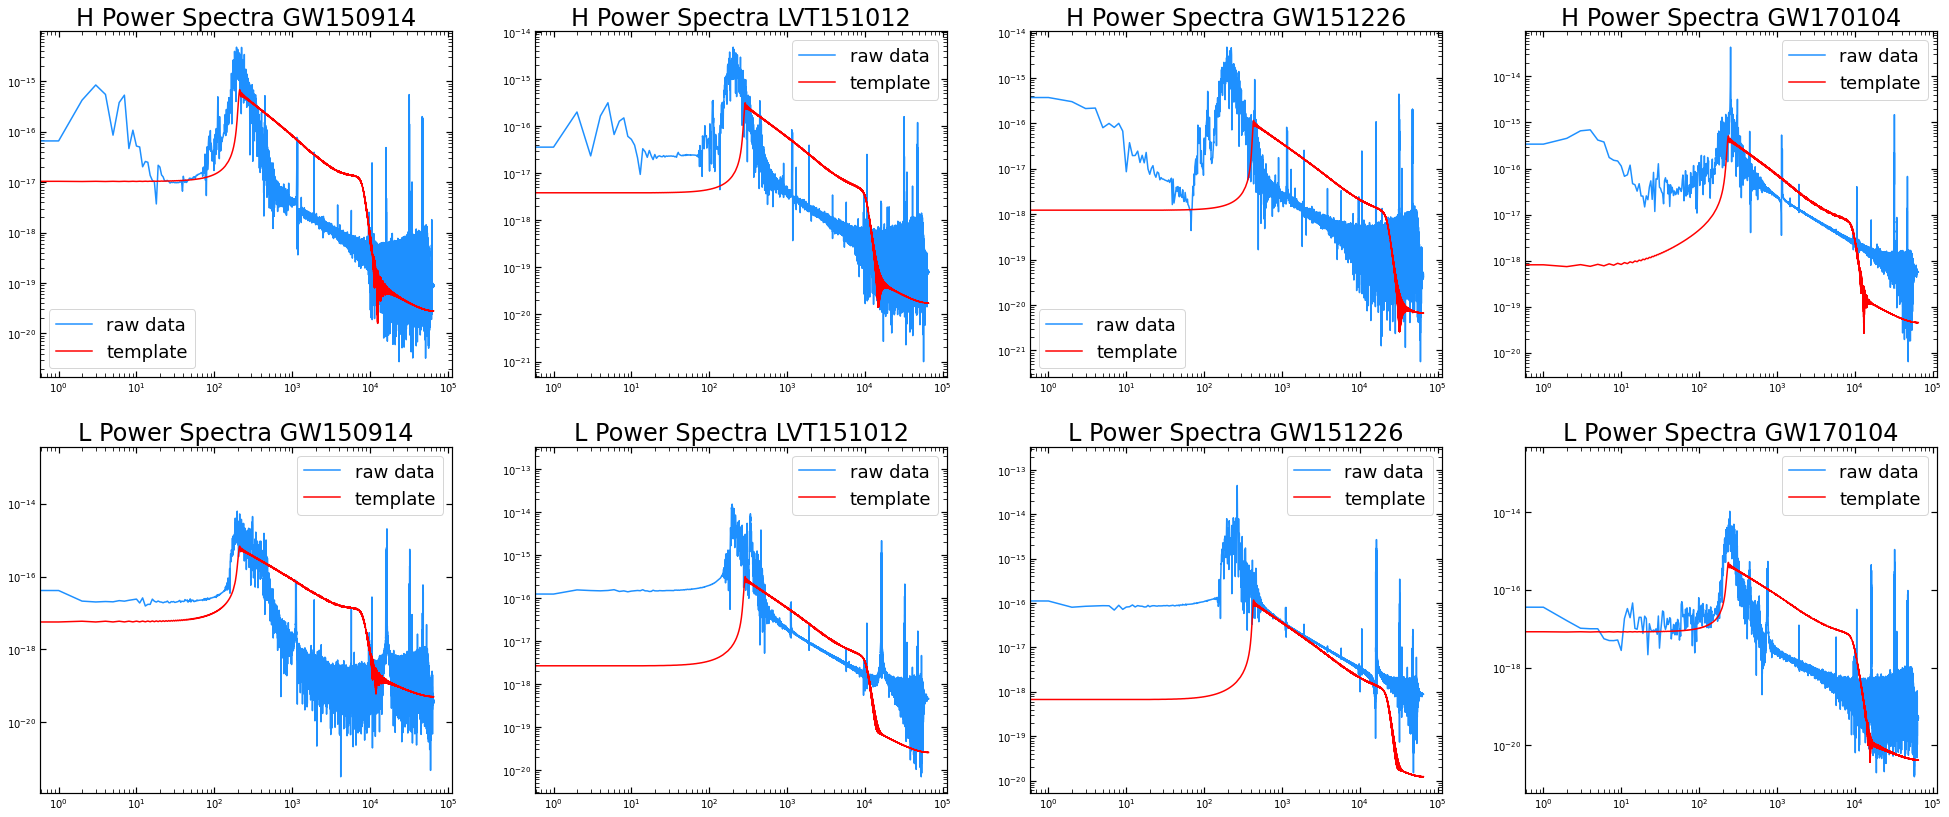

In [83]:
nrows, ncols = 2,4
fig,ax = plt.subplots(nrows,ncols, figsize=[34,14])

for j in range(ncols):
    ax[0,j].loglog(np.abs(np.fft.rfft(H1_data[j][0])), color='dodgerblue', label='raw data')
    ax[0,j].loglog(np.abs(np.fft.rfft(H_templates[j])), color='red', label = 'template')
    ax[0,j].legend(fontsize=18)
    ax[0,j].set_title('H Power Spectra '+str(list_events[j]), fontsize=24)
    ax[1,j].loglog(np.abs(np.fft.rfft(L1_data[j][0])),color='dodgerblue', label='raw data')
    ax[1,j].loglog(np.abs(np.fft.rfft(L_templates[j])),  color='red',label = 'template')
    ax[1,j].legend(fontsize=18)
    ax[1,j].set_title('L Power Spectra '+str(list_events[j]), fontsize=24)

Clearly, the data is very spikey, especially at larger frequencies, so we can try to smooth this out.